# Анализ оттока клиентов

## Описание проекта

В банке необходимо провести анализ оттока клиентов, который должен показать, как клиенты пользуются услугами банка, а также по результатам анализа необходимо составить портрет клиентов, которые склонны уходить из банка.

## Описание данных

В датасете bank_scrooge.csv хранятся данные о клиентах банка с характеристиками клиентов.

Файл bank_scrooge.csv содержит следующие столбцы:
- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City / city — город,
- Gender / gender — пол,
- Age / age — возраст,
- Objects — количество объектов в собственности
- equity — приблизительная оценка собственности клиента,
- Balance / balance — баланс на счёте,
- Products / products — количество продуктов, которыми пользуется клиент,
- CreditCard / credit_card — есть ли кредитная карта,
- Loyalty / last_activity — был ли клиент активен последнее время,
- estimated_salary / salary — оценочная заработная плата клиента
- Churn / churn — уходит или нет

## Задачи анализа

1. Провести исследовательский анализ, включающий исследование корреляций и портретов клиентов.
2. Проверить гипотезы, отслеживая применимость используемого стат.критерия к исследуемым данным.
3. Сделать выводы о том, какие признаки стратегическим образом влияют на отток и какие значения или интервалы этих признаков связаны с оттоком.
4. Выделить не мелкие, но компактные высокоотточные сегменты, приоритизировать их.
5. Дать конкретные рекомендации по приоритетным сегментам.
6. Подготовить презентацию со всеми ключевыми моментами.

## Ход анализа

1. Загрузка и изучение данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Проверка статистических гипотез.
6. Сегментация на основе стратегических показателей.
7. Выводы и рекомендации (конкретные, по конкретным сегментам) для заказчика.

## Загрузка и изучение данных

In [1]:
pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from phik import report
import numpy as np
import scipy
import scipy.stats
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df = pd.read_csv(path)

Загрузим функцию, которая будет принимать на вход датафрейм, а на выходе она будет выводить всего нужные характеристики.

In [4]:
def load_info(df):
    display(df.head())
    print(df.info())
    display(df.describe())

load_info(df)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None


,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


### Вывод

- В датасете 10000 строк.
- Возраст от 18 до 86 лет.
- Есть нулевая собственность.
- Есть нулевые продукты.
- В 2-х столбцах age и balance есть пропуски. 
- Тип данных в столбцах age и score должен быть целым. 
- Приведем названия столбцов к нижнему регистру.

## Предобработка данных

### Приведем названия столбцов к одному регистру

In [5]:
df.columns = df.columns.str.lower()

### Преобразуем данные в нужные типы

In [6]:
df['age'] = df['age'].astype('Int64')
df['score'] = df['score'].astype('Int64')

### Исследуем пропуски

In [7]:
df.isna().sum()

userid              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

Возраст имеет ключевое значение для анализа. Удалим нулевые значения возраста.

In [8]:
df = df.dropna(subset=['age'])

In [9]:
df.isna().sum()

userid              0
score               0
city                0
gender              0
age                 0
equity              0
balance          2279
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9974 non-null   int64  
 1   score          9974 non-null   Int64  
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   Int64  
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
dtypes: Int64(2), float64(2), int64(6), object(2)
memory usage: 1.0+ MB


После удаления в датасете осталось 9974 строки, 26 удалено.

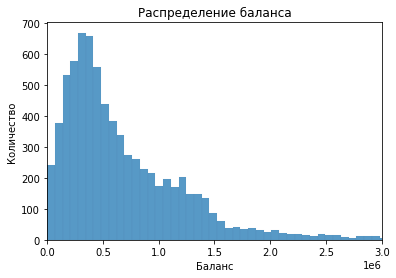

In [11]:
sns.histplot(df['balance'])
plt.title('Распределение баланса')
plt.xlabel('Баланс')
plt.xlim((0, 3*1e6))
plt.ylabel('Количество')
plt.show()

### Проведем проверку на явные и неявные дубликаты

In [15]:
df.duplicated().sum()

0

In [16]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

Исследовать дубликаты отдельно в категориальных значениях city, gender, age, equity, products, credit_card, last_activity, churn не имеет смысла. Посмотрим дубликаты в остальных столбцах.

In [17]:
t = df[df.duplicated(['userid'])]
t

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1583,190253,726,Ярославль,М,49,0,NaN,1,1,1,177700.78,0
1837,210662,896,Рыбинск,Ж,37,0,NaN,2,0,0,90916.04,0
2138,131419,739,Рыбинск,Ж,37,3,1307941.65,3,0,0,103867.47,0
2302,220816,934,Рыбинск,Ж,74,5,1294285.39,3,1,0,95606.80,0
2998,208081,821,Рыбинск,Ж,62,3,493608.26,2,1,1,33491.45,0
3039,170312,813,Рыбинск,Ж,47,3,370027.67,2,0,0,129835.56,0
3106,185748,912,Ярославль,Ж,47,5,1598218.98,2,0,0,180256.98,0
3817,211130,918,Рыбинск,Ж,55,0,NaN,2,1,1,244202.04,0
4186,217643,804,Рыбинск,Ж,40,2,301836.65,2,1,1,81137.22,0
4216,226719,903,Рыбинск,Ж,63,0,NaN,1,1,0,138582.58,0


Есть дубликаты по userid. Исследуем эти дубликаты в разрезе городов, баланса и дохода.

In [18]:
t = df[df.duplicated(['userid', 'city'])]
t

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


In [19]:
t = df[df.duplicated(['userid', 'balance'])]
t

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


In [20]:
t = df[df.duplicated(['userid', 'est_salary'])]
t

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


In [21]:
t = df[df.duplicated(['userid', 'churn'])]
t

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


Выведем пример дубликата по userid.

In [22]:
t = df.query('userid == 131419')
t

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
904,131419,934,Ярославль,М,35,5,2348335.95,2,0,0,217105.13,1
2138,131419,739,Рыбинск,Ж,37,3,1307941.65,3,0,0,103867.47,0


Дубликаты по userid явно связаны с разными городами. Вернее всего это один и тот же клиент, который обращался в банк в разных городах. Баланс в более поздней строки датасета имеет значение NaN. Скорее всего это в первом городе он закрыл счета, во втором открыл, т.к. это все города Ярославской области. Более точной информации у нас нет, и подтвердить данное предположение нет возможности, поэтому оставим дубликаты по id.

## Исследовательский анализ данных

### Общее количество оттока клиентов у банка и его доля

Общее количество оттока.

In [23]:
df['churn'].sum()

1819

Доля оттока из общего количества клиентов.

In [24]:
df['churn'].sum() / 9974 * 100

18.237417284940847

### Корреляционный анализ

Построим корреляционную матрицу, используя phik_matrix метод.

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


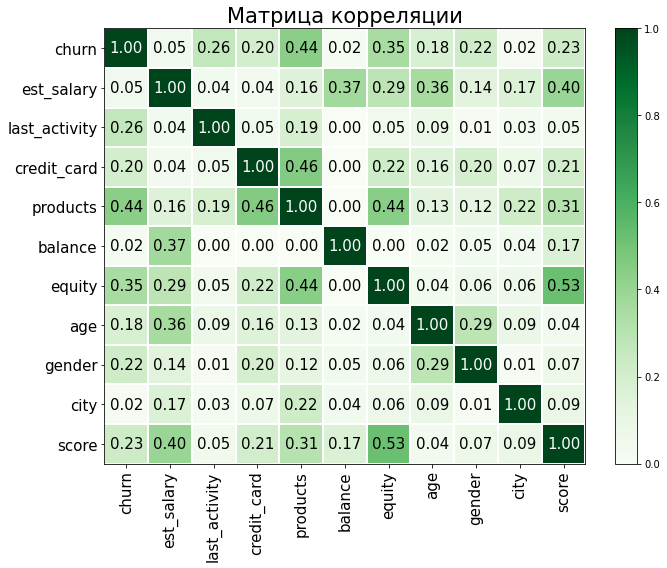

In [25]:
phik_overview = df.drop('userid', axis = 1).phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляции", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Из матрицы корреляций видно, что есть зависимости между собственностью и кредитным скором, собственностью и продуктами, доходом и кредитным скором, доходом и возрастом.

Но нас интересуют зависимости оттока клиентов от его характеристик. 

Отток коррелирует с продуктами, собственностью, активностью, скором, полом, кредитной картой и возрастом.

Нет корреляции с городом, доходом и балансом.

### Корреляции

Проверим корреляции с характеристиками:

- кредитный скоринг
- город
- пол
- возраст
- оценка собственности клиента
- баланс
- количество продуктов
- наличие кредитной карты
- активность
- доход

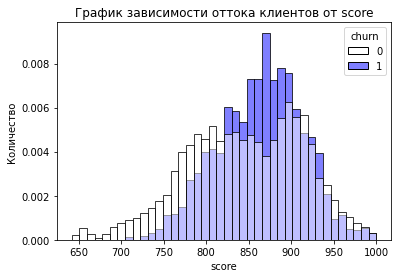

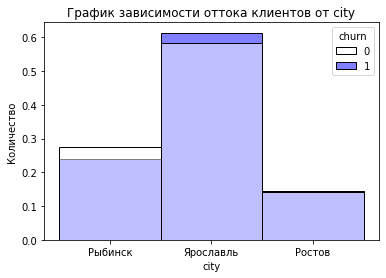

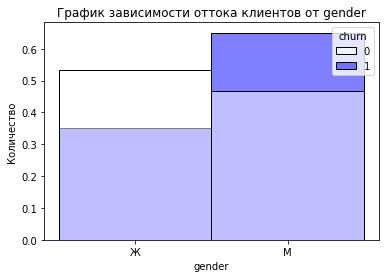

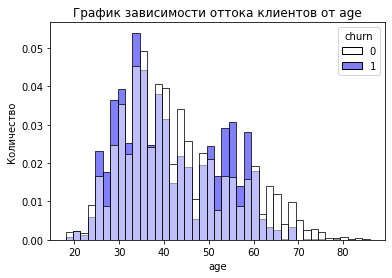

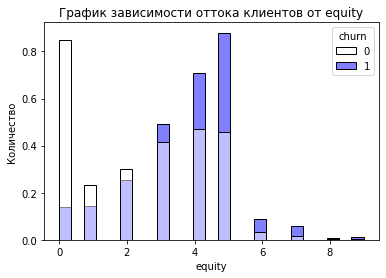

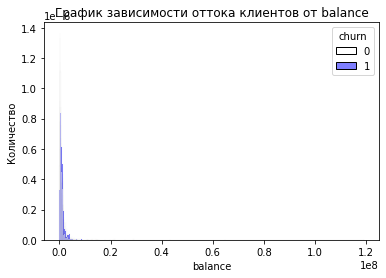

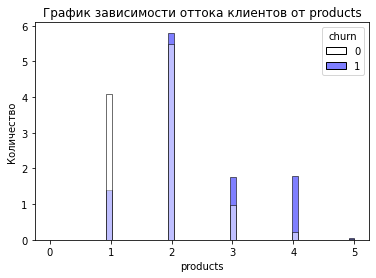

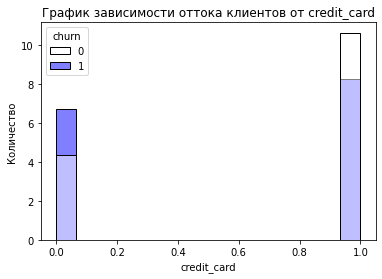

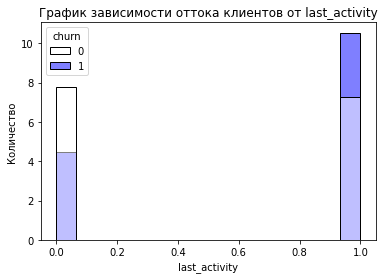

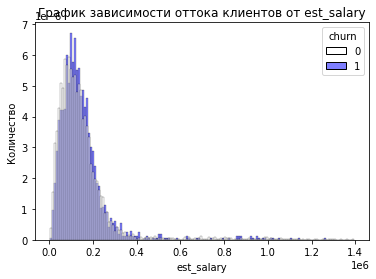

In [26]:
columns = ['score', 'city', 'gender', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary']

for col in columns:
    sns.histplot(data=df, hue='churn', x=col, stat='density', common_norm=False, palette='flag')
    plt.ylabel('Количество')
    plt.title(f'График зависимости оттока клиентов от {col}')
    plt.show()

1. Зависимость от кредитного скоринга: отток значительный при кредитном скоринге 830-940.

2. Зависимость от города: в Ярославле отток больше. Ярославль - это столица области, общее количество клиентов значительно превышает Рыбинск и Ростов.

3. Зависимость от пола: среди мужчин отток выше.

4. Зависимость от возраста: отток есть в группе 25-60 лет.

5. Зависимость от оценки собственности клиента: оценки выше 3х отток значительный. Больше всего при оценке 5. Оценки 3, 4, 5, 6, 7 - наиболее высокий отток.

6. Зависимость от баланса: есть выбросы, корреляцию сложно отследить.

7. Зависимость от количества продуктов: отток есть при количестве продуктов 2, 3, 4 и 5. При количестве 4 - самый высокий отток.

8. Зависимость от кредитной карты: при отсутствии кредитной карты отток выше. 

9. Зависимость от активности: отток выше при активности.

10. Зависимость от дохода: есть выбросы, корреляцию сложно отследить.


Проведем исследование оттока с разбивкой по городам, добавим в сводную таблицу общее количество клиентов (total), и процент ушедших от общего количества (share).

In [27]:
t = df.query(
    'churn == 1').groupby(
    'city').agg(
    {'userid':'count'}).sort_values(by=('userid'), ascending=True).rename(columns={'userid':'count'})
t['total'] = df.groupby('city').agg({'userid':'count'}).sort_values(by=('userid'), ascending=False)['userid']
t['share'] = t['count'] / t['total'] * 100
t = t.sort_values(by=('share'), ascending=True).reset_index()
t

,city,count,total,share
0,Рыбинск,437,2683,16.287738
1,Ростов,265,1416,18.714689
2,Ярославль,1117,5875,19.012766


Явной корреляции по городам нет. Ярославль как столица области лидирует.

### Корреляции по возрасту

Выявим возрастные группы, которые представлены в данных

<AxesSubplot:xlabel='age', ylabel='Density'>

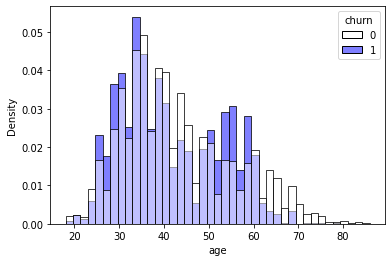

In [28]:
sns.histplot (data=df, 
              hue='churn', 
              x='age', 
              stat='density', 
              common_norm=False, 
              palette='flag')

Из гистограммы видно, что отток идет больше от 24 до 60 лет. 

От 18-23 и 61-86 оттока нет.

Выделим следующие категории:
- 18-23 лет
- 24-34 лет
- 35-48 лет
- 49-60 лет
- 61-86 лет

Используем функцию с именем categorize_age() и метод apply().

In [29]:
def categorize_age(age):
    try:
        if 18 <= age <= 23:
            return '18-23'
        elif 24 <= age <= 34:
            return '24-34'
        elif 35 <= age <= 48:
            return '35-48'
        elif 49 <= age <= 60:
            return '49-60'
        elif 61 <= age <= 86:
            return '61-86'        
    except:
        pass

In [30]:
df_1 = df.copy()

In [31]:
df_1['age_category'] = df_1['age'].apply(categorize_age)

Посмотрим и сравним доли оттока в возрастных группах.

In [32]:
t = df_1.query(
    'churn == 1').groupby(
    'age_category').agg(
    {'userid':'count'}).sort_values(by=('userid'), ascending=True).rename(columns={'userid':'count'})
t['total'] = df_1.groupby('age_category').agg({'userid':'count'}).sort_values(by=('userid'), ascending=False)['userid']
t['share'] = t['count'] / t['total'] * 100
t = t.sort_values(by=('age_category'), ascending=True).reset_index()
t

,age_category,count,total,share
0,18-23,18,147,12.244898
1,24-34,604,2756,21.915820
2,35-48,631,4084,15.450539
3,49-60,499,1954,25.537359
4,61-86,67,1033,6.485963


Группы 18-23 и 61-86 как показала гистограмма и анализ данных доля оттока из общего числа низкая. 

Также и у группы 35-48 доля оттока ниже общей доли оттока по датасету. 

Таким образом, высокоотточные группы: 24-34 и 49-60.

### Корреляции по балансу 

<AxesSubplot:xlabel='balance', ylabel='Density'>

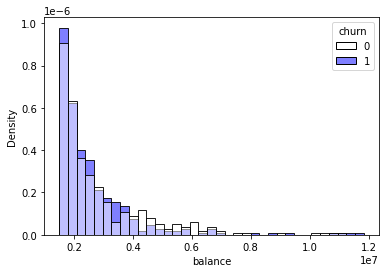

In [33]:
t = df.query('balance > 1500000 and balance < 12000000')
sns.histplot (data=t, 
              hue='churn', 
              x='balance', 
              stat='density', 
              common_norm=False, 
              palette='flag')

In [34]:
def categorize_balance(balance):
    try:
        if 0 <= balance <= 1500000:
            return '0 - 1.5 млн'
        elif 1500000 < balance <= 4000000:
            return '1.5 млн - 4 млн'
        elif 4000000 < balance <= 8000000:
            return '4 млн - 8 млн'
        elif 8000000 < balance <= 120000000:
            return '8 млн - 120 млн'               
    except:
        pass

In [35]:
df_1['balance_category'] = df_1['balance'].apply(categorize_balance)

In [36]:
t = df_1.query(
    'churn == 1').groupby(
    'balance_category').agg(
    {'userid':'count'}).sort_values(by=('userid'), ascending=True).rename(columns={'userid':'count'})
t['total'] = df_1.groupby('balance_category').agg({'userid':'count'}).sort_values(by=('userid'), ascending=False)['userid']
t['share'] = t['count'] / t['total'] * 100
t = t.sort_values(by=('balance_category'), ascending=True).reset_index()
t

,balance_category,count,total,share
0,0 - 1.5 млн,1446,6976,20.728211
1,1.5 млн - 4 млн,322,608,52.960526
2,4 млн - 8 млн,24,80,30.000000
3,8 млн - 120 млн,14,31,45.161290


Большая доля оттока в группе по балансу 1,5 млн-4 млн.

Группы больше 4 млн. малочисленны.

 ### Корреляции по доходу

<AxesSubplot:xlabel='est_salary', ylabel='Density'>

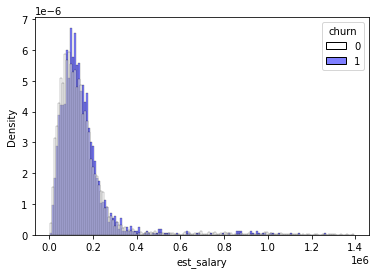

In [37]:
sns.histplot (data=df, 
              hue='churn', 
              x='est_salary', 
              stat='density', 
              common_norm=False, 
              palette='flag')

In [38]:
df['est_salary'].min()

2546.3

In [39]:
df['est_salary'].max()

1395064.45

<AxesSubplot:xlabel='est_salary', ylabel='Density'>

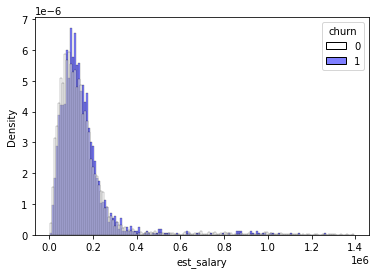

In [40]:
sns.histplot (data=df, 
              hue='churn', 
              x='est_salary', 
              stat='density', 
              common_norm=False, 
              palette='flag')

In [41]:
def categorize_est_salary(est_salary):
    try:
        if 0 <= est_salary <= 90000:
            return '1. 0 - 90 тыс'        
        elif 90000 < est_salary <= 300000:
            return '2. 90 тыс - 300 тыс'
        elif 300000 < est_salary <= 600000:
            return '3. 300 тыс - 600 тыс'
        elif 600000 < est_salary <= 1400000:
            return '4. 600 тыс - 1,4 млн'                      
    except:
        pass

In [42]:
df_1['est_salary_category'] = df_1['est_salary'].apply(categorize_est_salary)

In [43]:
t = df_1.query(
    'churn == 1').groupby(
    'est_salary_category').agg(
    {'userid':'count'}).sort_values(by=('userid'), ascending=True).rename(columns={'userid':'count'})
t['total'] = df_1.groupby('est_salary_category').agg({'userid':'count'}).sort_values(by=('userid'), ascending=False)['userid']
t['share'] = t['count'] / t['total'] * 100
t = t.sort_values(by=('est_salary_category'), ascending=True).reset_index()
t

,est_salary_category,count,total,share
0,1. 0 - 90 тыс,526,3342,15.739078
1,2. 90 тыс - 300 тыс,1198,6070,19.736409
2,3. 300 тыс - 600 тыс,67,336,19.940476
3,"4. 600 тыс - 1,4 млн",28,226,12.389381


<AxesSubplot:xlabel='est_salary', ylabel='Density'>

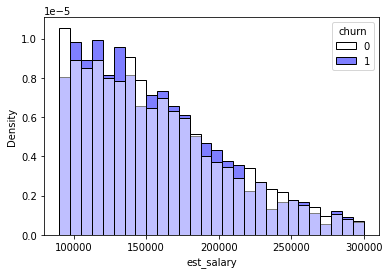

In [44]:
sns.histplot (data=df.query('est_salary > 90000 and est_salary < 300000'), 
              hue='churn', 
              x='est_salary', 
              stat='density', 
              common_norm=False, 
              palette='flag')

Высокий отток в группе по доходу 90 тыс-300 тыс. 

Также высокая доля оттока в группах больше 300 тыс., но эта группа малочисленная по ооставу клиентов.

### Портреты клиентов и их сравнение

#### Общий портрет клиентов

Используем для портрета клиентов следующие характеристики: город, пол, возраст, доход, кредитный скор, активность и наличие кредитной карты.

In [45]:
t = df.groupby(
    ['city', 'gender']).agg(
    {'userid':'count', 'age':'mean', 'score':'mean', 'est_salary':'mean', 'credit_card':'mean', 'last_activity':'mean'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})
t

count        age       score     est_salary  credit_card  \
city      gender                                                             
Ростов    М         683  41.143485  843.874085  119500.742606     0.631040   
          Ж         733  46.934516  841.493861  104080.675525     0.508868   
Рыбинск   М        1309  40.576776  847.449962  144025.455111     0.684492   
          Ж        1374  45.944687  849.690684  125962.761441     0.600437   
Ярославль Ж        2876  44.624826  848.759736  149410.537229     0.659944   
          М        2999  39.728243  851.536846  174994.544138     0.787262   

                  last_activity  
city      gender                 
Ростов    М            0.516837  
          Ж            0.545703  
Рыбинск   М            0.560733  
          Ж            0.564774  
Ярославль Ж            0.508345  
          М            0.496832

**Вывод**

Согласно проведенного анализа выявлены портреты клиентов банка среди городов и между мужчин и женщин. 

Сравним клиентов:
- возраст у всех клиентов от 40 до 46 лет
- женщин больше в двух городах, кроме Ярославля
- кредитный скор от 841 до 849
- доход 104 т - 174 т
- наличие кредитной карты у всех клиентов больше 0,5, значит ближе показатель наличия кредитной карты
- активность у всех 0,5, значит примерно одинаковое количество как активных так и неактивных клиентов.

Показатели количества клиентов и дохода в Ярославле выше, т.к. это столица региона.


#### Портрет отточных клиентов

In [46]:
t = df.query('churn == 1').groupby(
    ['city', 'gender']).agg(
    {'userid':'count', 'age':'mean', 'score':'mean', 'est_salary':'mean', 'credit_card':'mean', 'last_activity':'mean'}).sort_values(
    by=('city'), ascending=True).rename(columns={'userid':'count'})
t

count        age       score     est_salary  credit_card  \
city      gender                                                             
Ростов    Ж          90       43.6  858.144444  125133.983667     0.377778   
          М         175       42.4  852.222857  122905.825029     0.560000   
Рыбинск   Ж         139  46.280576  861.244604  119516.804317     0.359712   
          М         298  40.473154  863.211409  139156.541644     0.580537   
Ярославль Ж         407  42.299754  868.427518  149168.798329     0.474201   
          М         710  39.921127   864.48169  166443.949718     0.640845   

                  last_activity  
city      gender                 
Ростов    Ж            0.722222  
          М            0.628571  
Рыбинск   Ж            0.776978  
          М            0.724832  
Ярославль Ж            0.818182  
          М            0.626761

**Вывод**

Согласно проведенного анализа выявлены портреты отточных клиентов банка среди городов и между мужчин и женщин. 

Сравним клиентов:
- возраст у всех клиентов от 40 до 46 лет
- мужчин больше в каждом городе
- кредитный скор от 852 до 868
- доход 119 т - 166 т
- наличие кредитной карты у женщин меньше 0,5, значит кредитная карта отсутствует, у мужчин больше 0,5, значит ближе показатель наличия кредитной карты
- активность у всех больше 0,5, значит клиенты активны.

Показатели количества клиентов и дохода в Ярославле выше, т.к. это столица региона.

## Проверка статистических гипотез

### Отток зависит от возраста

Проверим гипотезу: отток зависит от возраста.

Сформулируем гипотезы.

Нулевая гипотеза: Возраст ушедших и оставшихся клиентов одинаков.

Альтернативная гипотеза: Возраст ушедших и оставшихся клиентов различен.

In [47]:
before = df.query('churn == 1')['age'].to_list()

after = df.query('churn == 0')['age'].to_list()

print(f'Количество 1 выборки: {len(before)}\nКоличество 2 выборки: {len(after)}\n')

alpha = .05 # критический уровень статистической значимости

results = scipy.stats.ttest_ind(
    before, 
    after)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Количество 1 выборки: 1819
Количество 2 выборки: 8155

p-значение:  6.503036883995611e-07
Отвергаем нулевую гипотезу


### Отток зависит от уровня дохода

Проверим гипотезу: отток зависит от уровня дохода.

Сформулируем гипотезы.

Нулевая гипотеза: Доход клиентов между теми клиентами, которые ушли и теми, которые остались равен.

Альтернативная гипотеза: Доход клиентов между теми клиентами, которые ушли и теми, которые остались различен.

In [48]:
before = df.query('churn == 1')['est_salary'].to_list()

after = df.query('churn == 0')['est_salary'].to_list()

print(f'Количество 1 выборки: {len(before)}\nКоличество 2 выборки: {len(after)}\n')

alpha = .05 # критический уровень статистической значимости

results = scipy.stats.ttest_ind(
    before, 
    after)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Количество 1 выборки: 1819
Количество 2 выборки: 8155

p-значение:  0.8647861589211189
Не получилось отвергнуть нулевую гипотезу


## Сегментация

Выделим наиболее значительные характеристики в сегменты и построим графики.

**Сегмент - клиенты мужчины с кредитным скором 830-950**

In [49]:
def categorize_est_score(score):
    try:
        if 0 <= score <= 830:
            return '0 - 830'
        elif 830 < score <= 950:
            return '830 - 950'
        elif 950 < score <= 1000:
            return '950 - 1000'                      
    except:
        pass

In [50]:
df_1['score_category'] = df_1['score'].apply(categorize_est_score)

In [51]:
t = df_1.query(
    'churn == 1 and gender == "М"').groupby(
    'score_category').agg(
    {'userid':'count'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})
t['total'] = df_1.query(
    'gender == "М"').groupby(
    'score_category').agg({'userid':'count'}).sort_values(by=('userid'), ascending=False)['userid']
t['share'] = t['count'] / t['total'] * 100
t = t.sort_values(by=('score_category'), ascending=True).reset_index()
t

,score_category,count,total,share
0,0 - 830,332,1937,17.139907
1,830 - 950,812,2822,28.773919
2,950 - 1000,39,232,16.810345


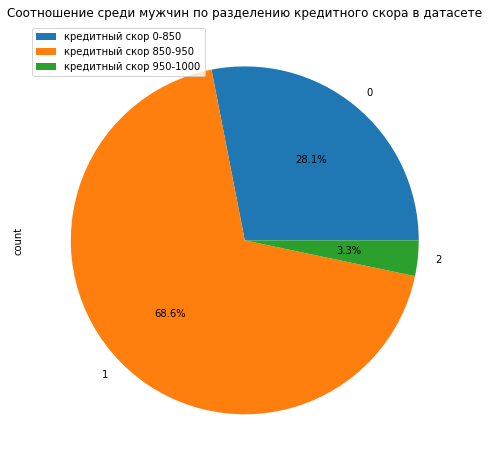

In [52]:
t.plot(y='count', kind='pie', figsize=(8,8), autopct='%1.1f%%')
plt.title('Cоотношение среди мужчин по разделению кредитного скора в датасете')
plt.legend(['кредитный скор 0-850', 'кредитный скор 850-950', 'кредитный скор 950-1000'])

**Вывод**

Сегмент: клиенты мужчины с кредитным скором 830-950 высокоотточен.

**Сегмент - активные клиенты с возрастом**

In [53]:
t = df_1.query(
    'churn == 1 and last_activity == 1').groupby(
    'age_category').agg(
    {'userid':'count'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})
t['total'] = df_1.query(
    'last_activity == 1').groupby('age_category').agg({'userid':'count'}).sort_values(by=('userid'), ascending=False)['userid']
t['share'] = t['count'] / t['total'] * 100
t = t.sort_values(by=('share'), ascending=True).reset_index()
t

,age_category,count,total,share
0,61-86,38,578,6.574394
1,18-23,15,85,17.647059
2,35-48,429,2022,21.216617
3,49-60,315,1004,31.374502
4,24-34,480,1526,31.454784


Text(0, 0.5, 'Доля оттока из общего количества клиентов')

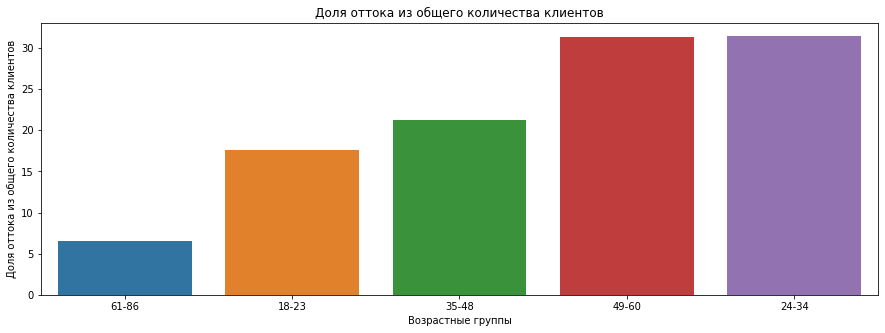

In [54]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='age_category', y='share', data=t)
plt.title('Доля оттока из общего количества клиентов')
plt.xlabel('Возрастные группы')
plt.ylabel('Доля оттока из общего количества клиентов')

**Вывод**

Сегмент: возраст клиента 24-34 и 49-60 и активность высокоотточен.

**Сегмент - клиенты с доходом от 90 т. до 300 т. по кредитному скору 830-950**

In [55]:
t = df_1.query(
    'churn == 1 and est_salary > 90000 and est_salary < 300000').groupby(
    'score_category').agg(
    {'userid':'count'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})
t['total'] = df_1.query(
    'est_salary > 90000 and est_salary < 300000').groupby('score_category').agg({'userid':'count'}).sort_values(by=('userid'), ascending=False)['userid']
t['share'] = t['count'] / t['total'] * 100
t = t.sort_values(by=('score_category'), ascending=True).reset_index()
t

,score_category,count,total,share
0,0 - 830,251,2148,11.685289
1,830 - 950,930,3730,24.932976
2,950 - 1000,17,192,8.854167


Text(0, 0.5, 'Кредитный скор')

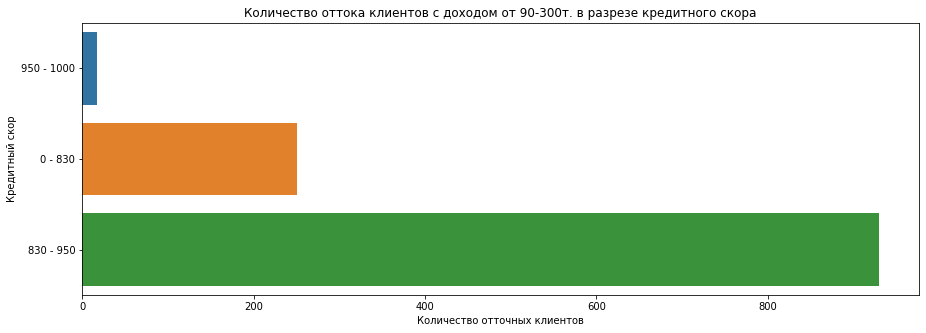

In [56]:
t = t.sort_values(by=('count'), ascending=True).reset_index()
plt.figure(figsize=(15,5))
ax = sns.barplot(x='count', y='score_category', data=t)
plt.title('Количество оттока клиентов с доходом от 90-300т. в разрезе кредитного скора')
plt.xlabel('Количество отточных клиентов')
plt.ylabel('Кредитный скор')

**Вывод**

Сегмент: клиенты с доходом 90-300 т. и кредитным скором 850-950 высокоотточен.

Выделим признаки и сопоставим их вместе по матрице корреляций

**Признаки:**

equity >= 3

equity = 5

products >= 2

products = 4

gender == "М"

last_activity == 1 

score >= 830 and score <=950

credit_card == 0

age >= 24 and age <= 60

age >= 24 and age <= 34

age >= 49 and age <= 60

### Сегмент 1 - отток зависит от продуктов, кредитной карты и собственности

In [57]:
#зададим условия для сегмента 
t = df.query('products >= 2 and equity >= 3 and credit_card == 0').groupby(
    'churn').agg(
    {'userid':'count'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})

t

,count
churn,
1,695
0,1380


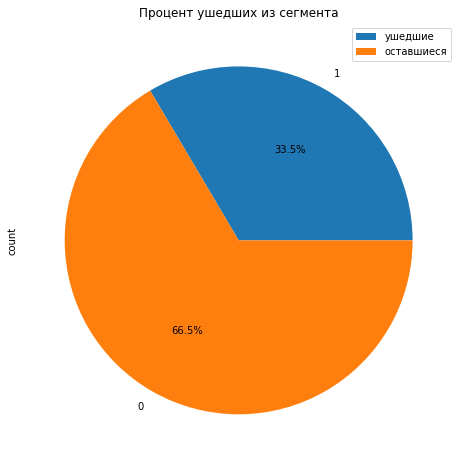

In [58]:
t.plot(y='count', kind='pie', figsize=(8,8), autopct='%1.1f%%')
plt.title('Процент ушедших из сегмента')
plt.legend(['ушедшие', 'оставшиеся'])

Сегмент с признаками 'products >= 2 and equity >= 3 and credit_card == 0' высокоотточный 33,5%

### Сегмент 2 - отток зависит от скора, дохода и собственности

In [59]:
#зададим условия для сегмента 
t = df.query('score >= 830 and score <=950 and equity == 5 and est_salary > 90000 and est_salary < 300000').groupby(
    'churn').agg(
    {'userid':'count'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})

t

,count
churn,
1,344
0,529


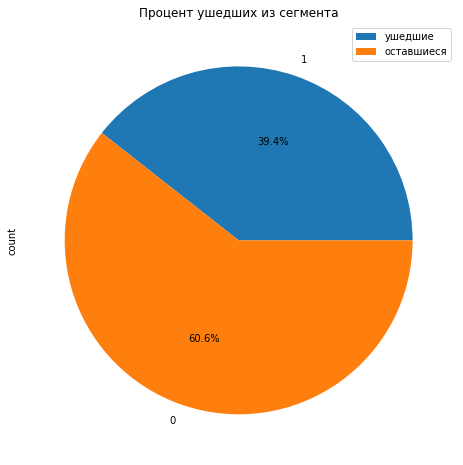

In [60]:
t.plot(y='count', kind='pie', figsize=(8,8), autopct='%1.1f%%')
plt.title('Процент ушедших из сегмента')
plt.legend(['ушедшие', 'оставшиеся'])

Сегмент с признаками 'score >= 830 and score <=950 and equity == 5 and est_salary > 90000 and est_salary < 300000' высокоотточный 39,4%

### Сегмент 3 - отток зависит от пола, кредитной карты и возраста

In [61]:
#зададим условия для сегмента 
t = df.query('gender == "М" and credit_card == 0 and age >= 24 and age <= 60').groupby(
    'churn').agg(
    {'userid':'count'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})

t

,count
churn,
1,436
0,781


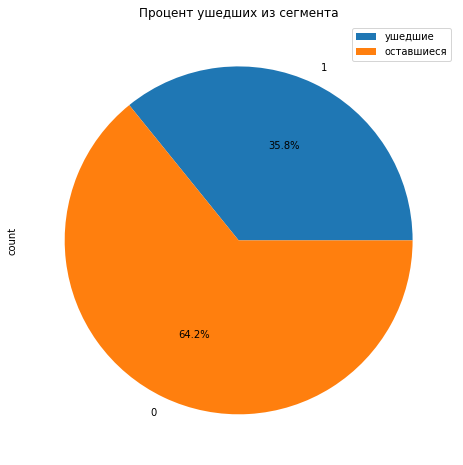

In [62]:
t.plot(y='count', kind='pie', figsize=(8,8), autopct='%1.1f%%')
plt.title('Процент ушедших из сегмента')
plt.legend(['ушедшие', 'оставшиеся'])

Сегмент с признаками 'gender == "М" and credit_card == 0 and age >= 24 and age <= 60' высокоотточный 35,8%

### Сегмент 4 - отток зависит от активности и продуктов

In [63]:
#зададим условия для сегмента 
t = df.query('last_activity == 1 and products > 2').groupby(
    'churn').agg(
    {'userid':'count'}).sort_values(
    by=('userid'), ascending=True).rename(columns={'userid':'count'})

t

,count
churn,
1,391
0,432


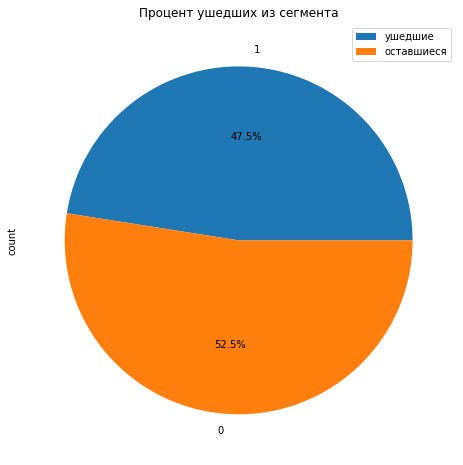

In [64]:
t.plot(y='count', kind='pie', figsize=(8,8), autopct='%1.1f%%')
plt.title('Процент ушедших из сегмента')
plt.legend(['ушедшие', 'оставшиеся'])

Сегмент с признаками 'last_activity == 1 and products > 2' высокоотточный 47,5%

### Кластеризация по машинному обучению

Выявим коррелиции признаков среди отточных клиентов. Количество кластеров n = 3.

Для начала нам нужно изменить строковые значения на числовые. У нас таких 2 столбца: пол и город

In [65]:
df_2 = df.copy()
df_2 = df_2.dropna(subset=['balance'])
df_2 = df_2.query('churn == 1')

In [66]:
def string_to_num(value):
    try:
        if value == 'Рыбинск':
            return 0
        elif value == 'Ярославль':
            return 1 
        elif value == 'Ростов':
            return 2   
        elif value == 'Ж':
            return 0   
        elif value == 'М':
            return 1
    except:
        pass

In [67]:
df_2['city'] = df_2['city'].apply(string_to_num)
df_2['gender'] = df_2['gender'].apply(string_to_num)

              score      city    gender        age    equity       balance  \
cluster                                                                      
0        943.314286  0.942857  0.771429  40.885714  4.542857  8.748735e+06   
1        886.961818  0.864545  0.606364  39.781818  4.434545  1.258768e+06   
2        821.043219  0.973174  0.713860  44.092399  2.690015  5.335031e+05   

         products  credit_card  last_activity     est_salary  
cluster                                                       
0        2.485714     0.514286       0.942857  778960.169429  
1        2.600000     0.387273       0.815455  150608.123809  
2        2.020864     0.816692       0.512668  108356.306200  


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


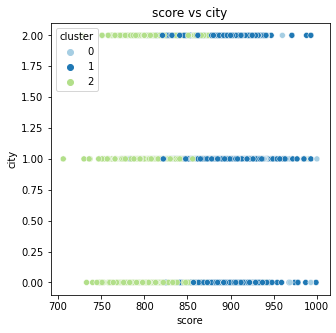

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


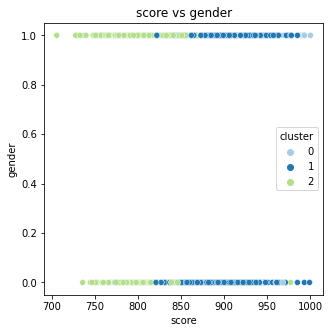

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


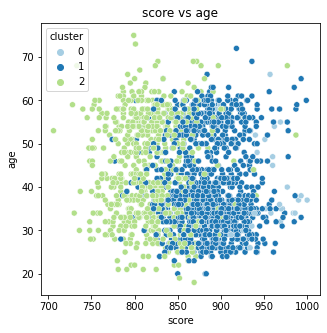

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


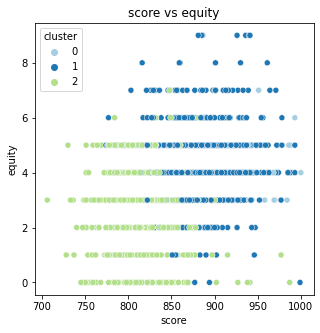

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


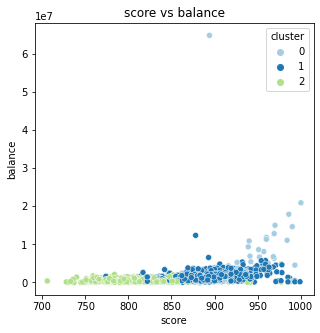

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


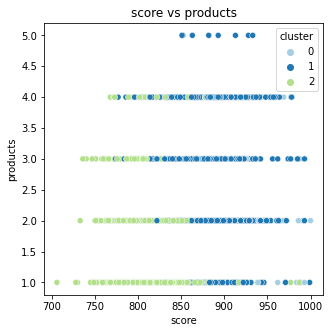

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


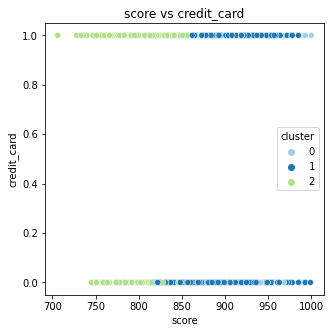

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


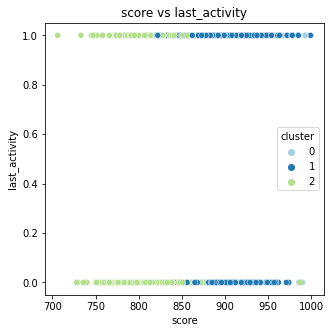

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


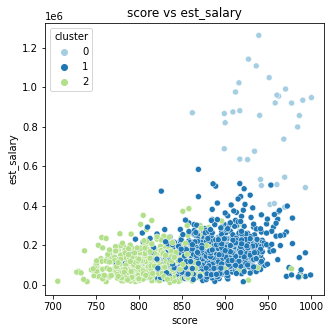

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


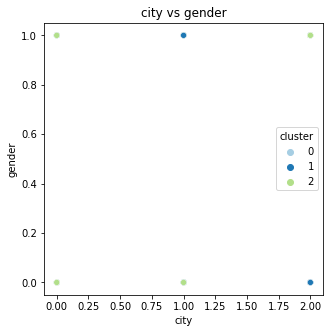

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


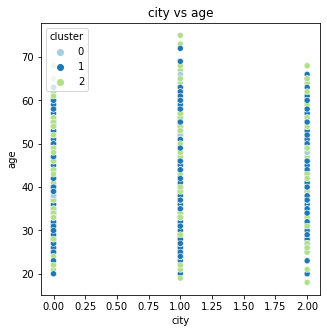

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


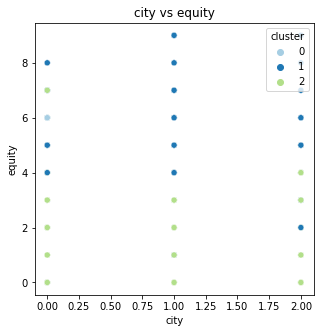

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


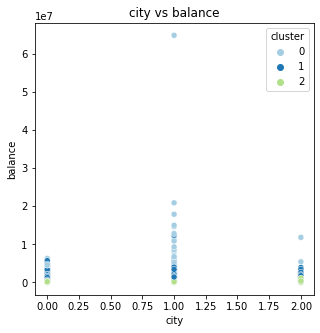

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


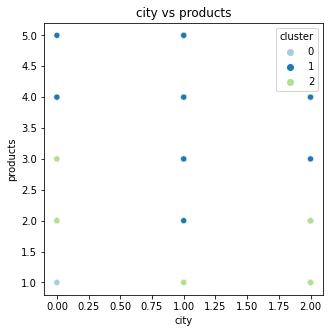

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


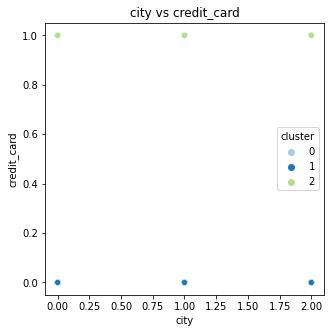

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


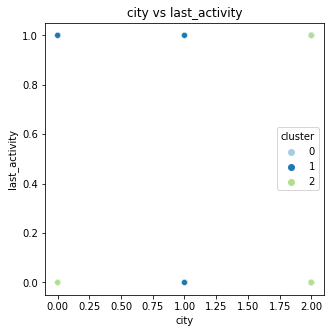

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


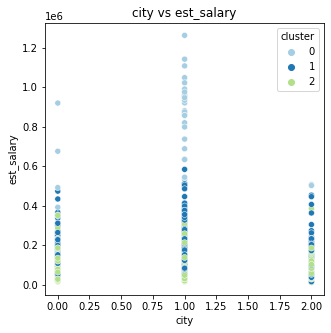

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


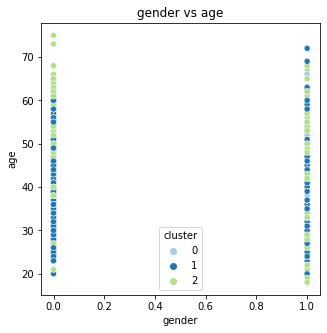

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


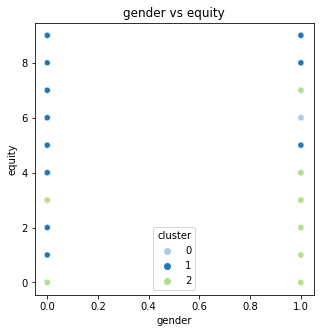

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


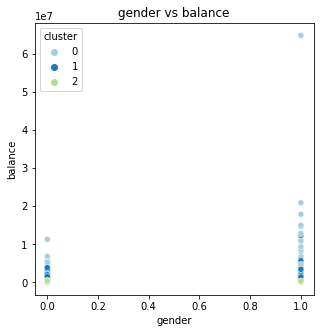

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


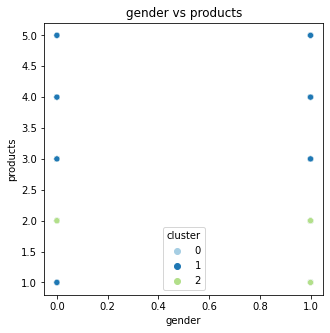

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


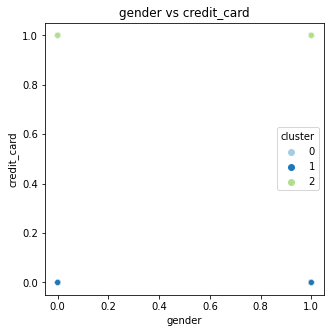

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


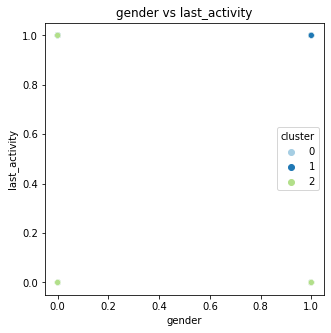

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


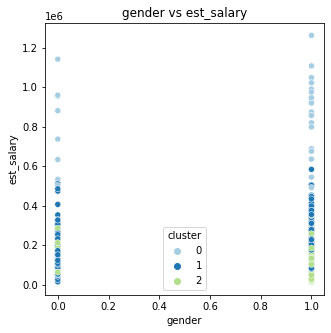

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


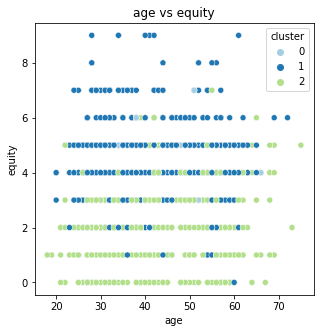

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


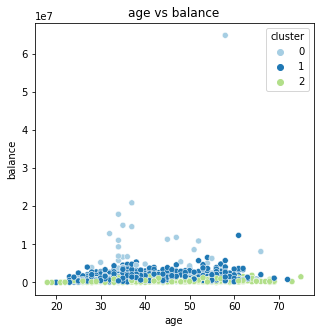

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


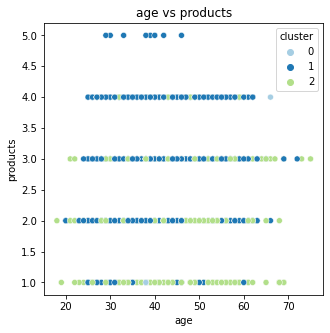

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


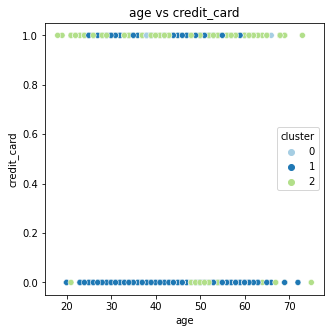

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


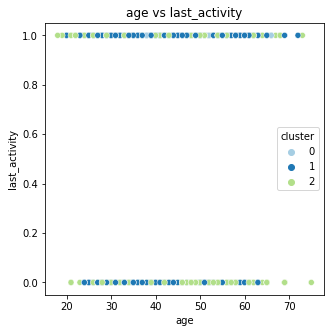

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


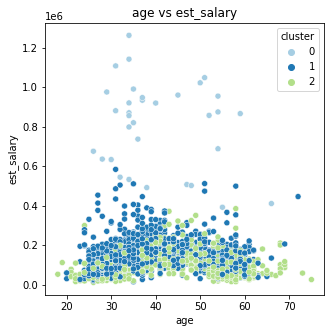

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


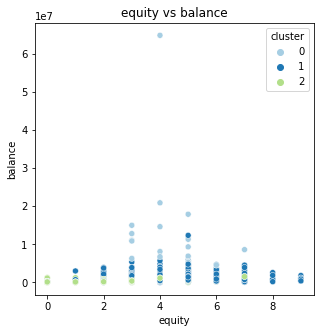

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


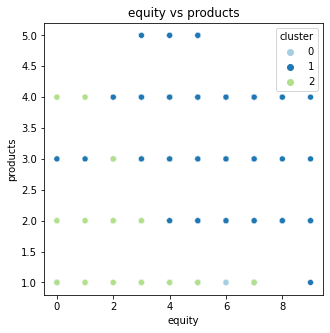

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


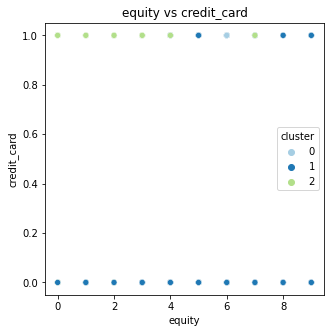

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


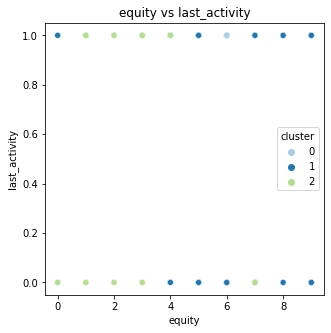

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


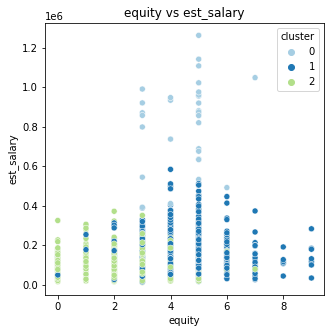

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


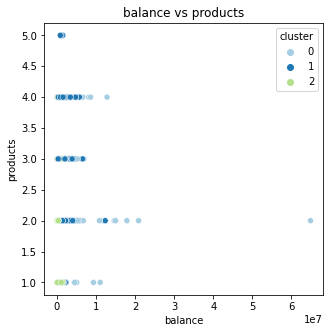

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


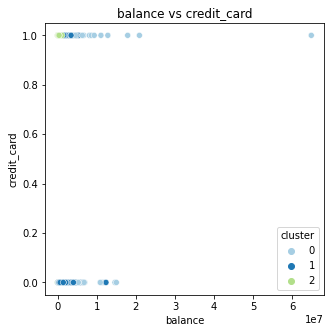

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


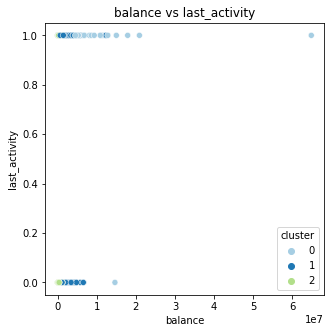

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


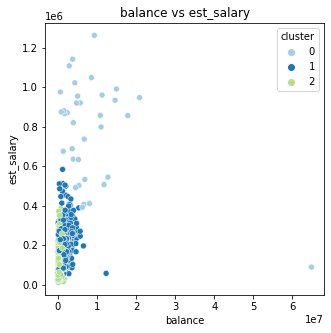

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


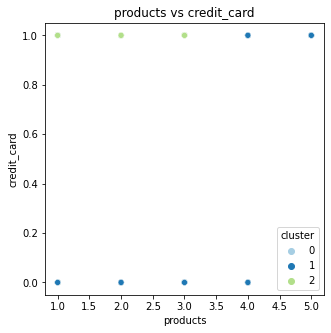

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


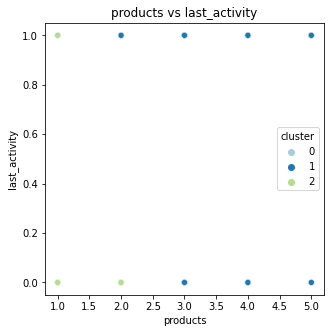

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


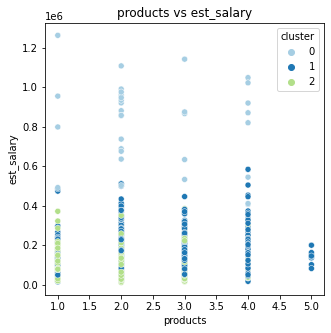

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


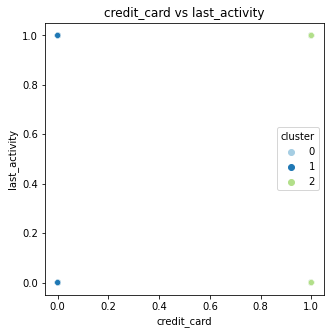

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


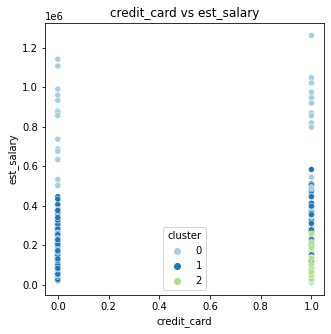

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


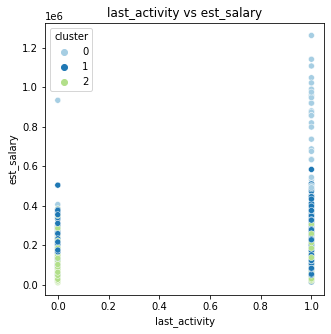

In [68]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

X = df_2.drop(['userid', 'churn'], axis=1)
y = df_2['userid']
    
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)

# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=3, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
X['cluster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
print(X.groupby('cluster').mean())

# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(X.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(X, pair[0], pair[1], 'cluster')

## Выводы и рекомендации

В датасете было 10000 строк, после удаления пропусков осталось 9974 строк.

Представлены клиенты мужчины и женщины из 3х городов Ярославской области - Рыбинск, Ростов, Ярославль,  возраст от 18 до 86 лет.

Отток среди клиентов банка составил 1819 человек, что составляет 18% от общего количества.

**Корреляционный анализ выявил зависимости оттока от следующих характеристик:**
- количество продуктов, 
- собственность,
- активность, 
- кредитный скор,
- пол, 
- кредитная карта,
- возраст.

**Корреляции по признакам**
1. Зависимость от кредитного скоринга: отток значительный при кредитном скоринге 830-940.
2. Зависимость от города: явной корреляции по городам нет, в Ярославле отток больше. Ярославль - это столица области, общее количество клиентов значительно превышает Рыбинск и Ростов.
3. Зависимость от пола: среди мужчин отток выше.
4. Зависимость от возраста: отток есть в группе 25-60 лет. В группах 18-23, 35-48 и 61-86 доля оттока низкая. Таким образом, высокоотточные группы: 35-48 и 61-86.
5. Зависимость от оценки собственности клиента: оценки выше 3х отток значительный. Больше всего при оценке 5. Оценки 3, 4, 5, 6, 7 - наиболее высокий отток.
6. Зависимость от количества продуктов: отток есть при количестве продуктов 2, 3, 4 и 5. При количестве 4 - самый высокий отток.
7. Зависимость от кредитной карты: при отсутствии кредитной карты отток выше.
8. Зависимость от активности: отток выше при активности.
9. Зависимость от дохода: высокий отток в группе по доходу 90 тыс-300 тыс. Также высокая доля оттока в группах больше 300 тыс., но эта группа малочисленная по составу клиентов.
10. Зависимость от баланса: большая доля оттока в группе по балансу 1,5 млн-4 млн. Группы больше 4 млн. малочисленны.


**Портреты отточных клиентов:**
- возраст у всех клиентов от 40 до 46 лет
- мужчин больше в каждом городе
- кредитный скор от 852 до 868
- доход 119 т - 166 т
- - наличие кредитной карты у женщин меньше 0,5, значит кредитная карта отсутствует, у мужчин больше 0,5, значит ближе показатель наличия кредитной карты
- активность у всех больше 0,5, значит клиенты активны.

**Гипотезы:**
- Гипотеза: отток зависит от возраста.

Нулевая гипотеза: Возраст ушедших и оставшихся клиентов одинаков.
Альтернативная гипотеза: Возраст ушедших и оставшихся клиентов различен.
Отвергаем нулевую гипотезу.

- Гипотеза: отток зависит от уровня дохода.

Нулевая гипотеза: Доход клиентов между теми клиентами, которые ушли и теми, которые остались равен.
Альтернативная гипотеза: Доход клиентов между теми клиентами, которые ушли и теми, которые остались различен.
Не получилось отвергнуть нулевую гипотезу

**Выскооточные сегменты:**
1. Сегмент с признаками 'products >= 2 and equity >= 3 and credit_card == 0' высокоотточный 33,5%
2. Сегмент с признаками 'score >= 830 and score <=950 and equity == 5 and est_salary > 90000 and est_salary < 300000' высокоотточный 39,4%
3. Сегмент с признаками 'gender == "М" and credit_card == 0 and age >= 24 and age <= 60' высокоотточный 35,8%
4. Сегмент с признаками 'last_activity == 1 and products > 2' высокоотточный 47,5%

**Рекомендации:**
- уже ушедшим клиентам предложить вернуться, предоставив по имеющимся каналам связи информацию о продуктах на основании выявленных портретов клиента банка, а также оставить положительное впечатление о банке среди тех, кто точно ушел и не вернется
- выявленные сегменты находятся в зоне риска, таким клиентам должно быть повышенное внимание - информирование о продуктах, обратная связь, обучение по новым продуктам, уникальные предложения, скидки, сервис, бесплатное обслуживание и проч.
- улучшить сервис согласно жалобам и плохим отзывам (наладить обратную связь с клиентами, которые оставили жалобу или плохой отзыв, принести извинения, предложить бонус, скидки у партнеров)
- удержать тех, кто не входит в зону риска, т.к. это ценные клиенты для банка




## Презентация

Презентация: <https://disk.yandex.ru/i/wl4Znl3_4F2BAA>

## Дашборд

Дашборд: <https://public.tableau.com/views/bank_16802041082020/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link>
